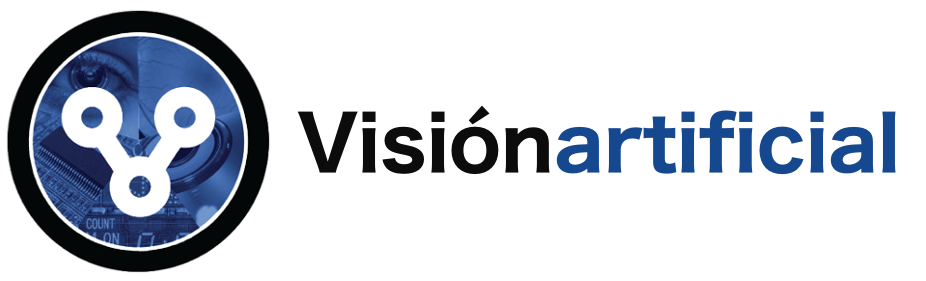

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

Este código é unha implementación directa e didáctica do trabalo de  Frank P. Kuhl, Charles Giardina,[Elliptic Fourier Features of a Closed Contour](./artigos/Kuhl-Giardina-CGIP1982.pdf) de 1981. Neste taballo se explica como obter os coeficientes Elípticos dee Fourier, a reconstrución do contorno a partir deles e tamén, como normalizalos para poder empregalos como descriptores invariantes de forma.
Para unha implementación máis profesional podes empregar o paquete Pyefd que implementa estes descriptores en Python e Numpy. Para instalalo: pip install pyefd. Nesta URL https://opensourcelibs.com/lib/pyefd atoparas como achar os coeficientes, normalizalos e empregalos como descriptores en combianción con OpenCV.
Nota: Tamén se aporta un código de Alessandro Ferrari para achar e normalizar os coreficientes Elípticos de Fourier (descriptores de contorno) se queres saber como . Ver o código apartado no cartafol elliptic-fourier-descriptors-master. 

# Descriptores elipticos de Fourier

In [26]:
#importamos os paquetes necesarios
from __future__ import print_function
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [27]:
#Cargamos as coordenedanas XY dun contorno de proba
#que están grabadas nun ficheiro de texto e non nunha imaxe
M = np.loadtxt('Gomphonema.txt')

### Ecuacións para obter os coeficientes de fourier

$$a_n= \frac{T}{2\pi^{2}n²}\sum_{p=1}^K\,\frac{\Delta x_p}{\Delta t_p}\left(\cos\frac{2\pi n t_p}{T}-\cos\frac{2\pi n t_{p-1}}{T}\right)$$

$$b_n= \frac{T}{2\pi^{2}n²}\sum_{p=1}^K\,\frac{\Delta x_p}{\Delta t_p}\left(\sin\frac{2\pi n t_p}{T}-\sin\frac{2\pi n t_{p-1}}{T}\right)$$

In [28]:
#funcion para obter os coeficientes de fourier
def efourier (M,n=len(M)/2):
    dfM=pd.DataFrame(M)            #recollemos os datos coa libraria pandas Dataframes
    Mx=pd.DataFrame(dfM[0])        
    My=pd.DataFrame(dfM[1])
    My.columns=[0]
    n=int(len(Mx)/2)                    #numero de Harmónicos dexados
    p=len(Mx)                      #numero de puntos do contorno

    Dx= Mx-Mx.shift(+1)
    Dx=Dx.fillna(0)
    Dy= My-My.shift(+1)
    Dy= Dy.fillna(1)


    Dt=np.sqrt(Dx.values**2+Dy.values**2)
    t1=np.cumsum(Dt)
    t1=pd.DataFrame(t1)
    t1m1=t1.shift(+1)
    t1m1=t1m1.fillna(0)
    T=sum(Dt)

    an=np.zeros(n)
    bn=np.zeros(n)
    cn=np.zeros(n)
    dn=np.zeros(n)

    for i in range(1,n):
        an[i]=(T/(2*np.pi**2*i**2))*np.sum((Dx/Dt)*(np.cos(2*i*np.pi*t1/T)-np.cos(2*np.pi*i*t1m1/T)))                                   
        bn[i]=(T/(2*np.pi**2*i**2))*np.sum((Dx/Dt)*(np.sin(2*i*np.pi*t1/T)-np.sin(2*np.pi*i*t1m1/T)))
        cn[i]=(T/(2*np.pi**2*i**2))*np.sum((Dy/Dt)*(np.cos(2*i*np.pi*t1/T)-np.cos(2*np.pi*i*t1m1/T)))                             
        dn[i]=(T/(2*np.pi**2*i**2))*np.sum((Dy/Dt)*(np.sin(2*i*np.pi*t1/T)-np.sin(2*np.pi*i*t1m1/T)))


    ao=[2*np.sum(Mx.values*Dt/T)]
    co=[2*np.sum(My.values*Dt/T)]

    

    an=np.asarray(an)
    bn=np.asarray(bn)
    cn=np.asarray(cn)
    dn=np.asarray(dn)

    return pd.DataFrame(dict(an=an,bn=bn,cn=cn,dn=dn), columns=['an','bn','cn','dn']), ao, co, n

In [29]:
coef,ao,co,n=efourier(M) #obtemos os coeficientes 

### ecuación inversa dos descriptores de Fourier  

$$x(t)= \frac{a_0}{2}+\sum_1^{+\infty} a_n\, \cos n \omega t+b_n\,\sin n \omega t$$

In [30]:
#funcións para invertir os coeficientes de Fourier a coordenadas XY /reconstrución) 
theta = linspace(0,2*np.pi, n+1)
theta = np.delete(theta, n, 0)

def i_seno (i):
    return np.sin(i*theta)

def i_coseno (i):
    return np.cos(i*theta)
    
def iefourier(an,bn,cn,dn,k,n,ao,co):
    hx=np.zeros((k,n))
    hy=np.zeros((k,n))
    for i in np.arange(1,k):
        hx[i,]=an[i]*i_coseno(i)+bn[i]*i_seno(i)
        hy[i,]=cn[i]*i_coseno(i)+dn[i]*i_seno(i)


    sum_hx=sum(hx,0)
    sum_hy=sum(hy,0)

    x = sum_hx+ao[0]/2
    y = sum_hy+co[0]/2
    return pd.DataFrame(dict(x=x,y=y))

In [31]:
i=2 #numero de harmónimos+1

coords = iefourier(coef.an,coef.bn,coef.cn,coef.dn,i,n,ao,co)            

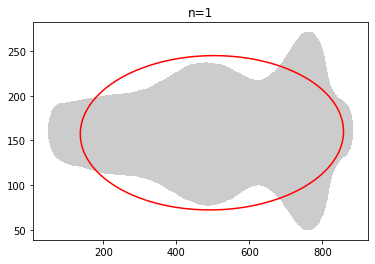

In [32]:
#representamos o contorno orixinal e a reconstrución a partir do n-esimo harmónico sobre el
plt.fill(M[:,0],M[:,1],'k', alpha=0.2)

plt.plot(coords['x'],coords['y'], 'r-')

figsize(9,3)
plt.title('n=%d'%(i-1))
#savefig('')
plt.show()

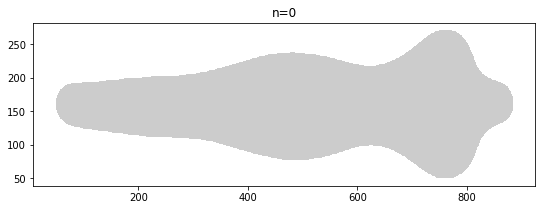

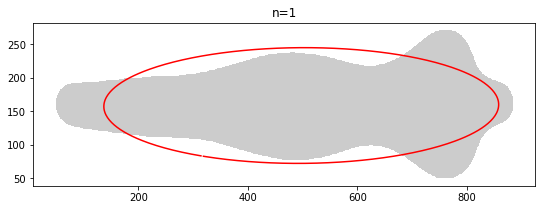

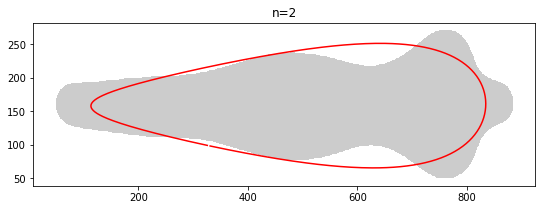

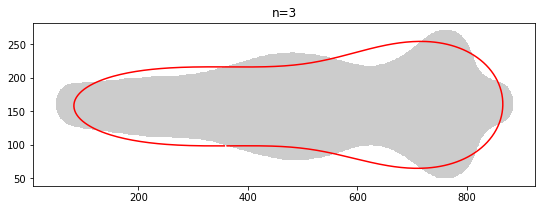

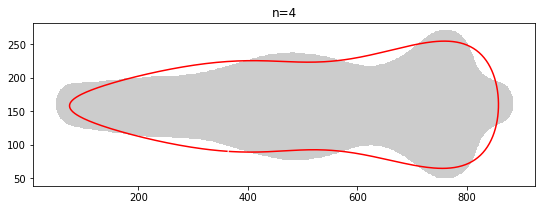

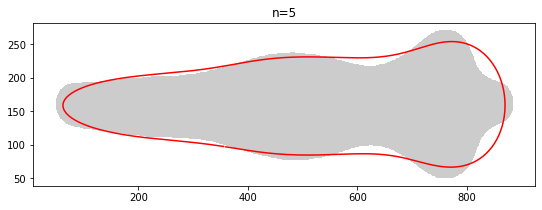

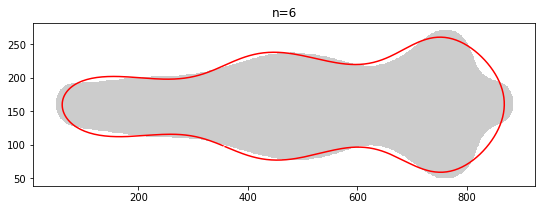

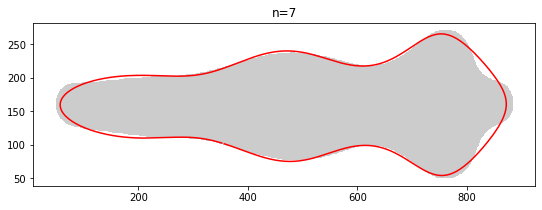

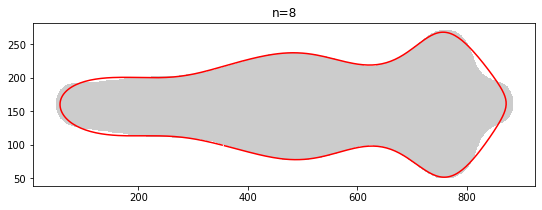

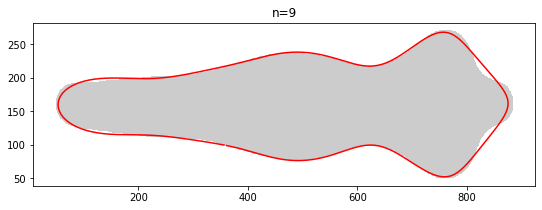

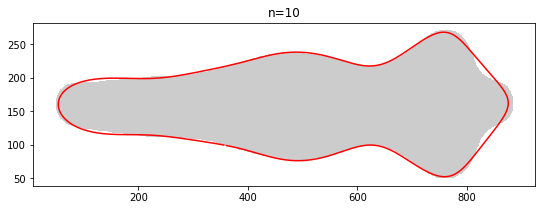

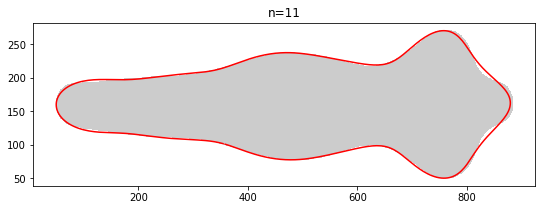

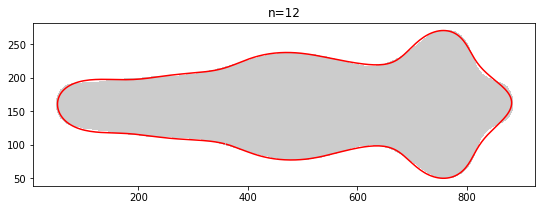

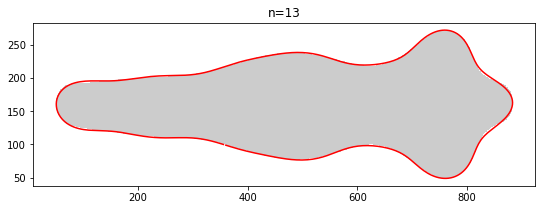

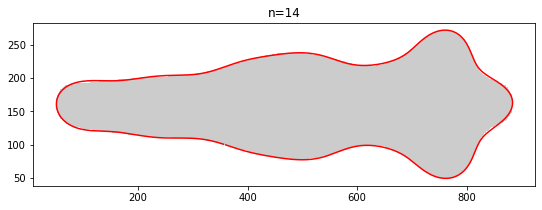

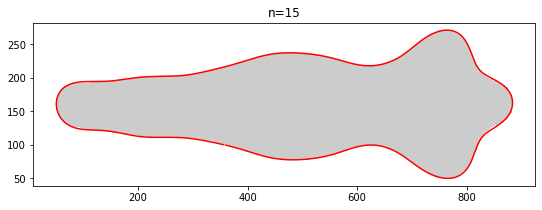

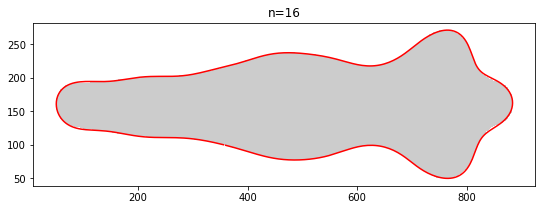

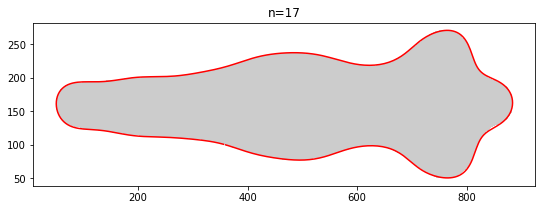

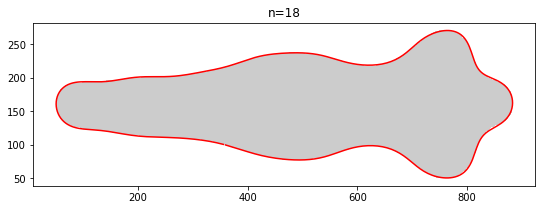

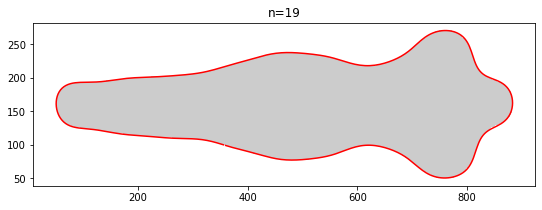

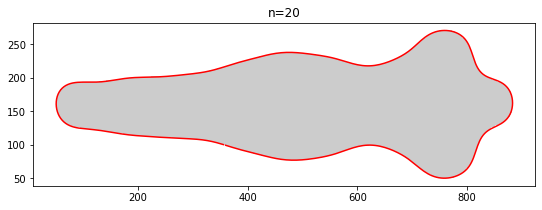

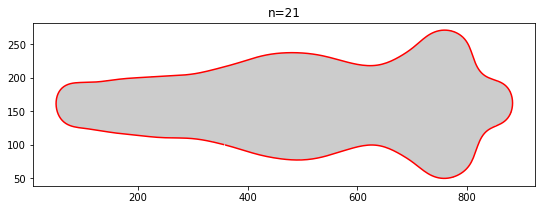

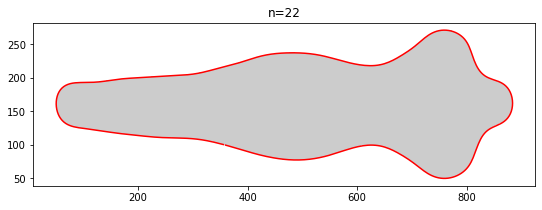

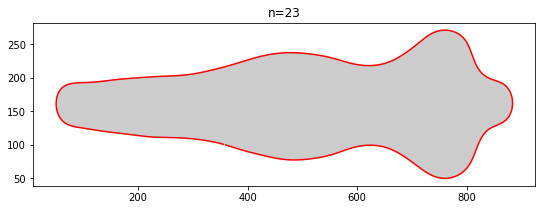

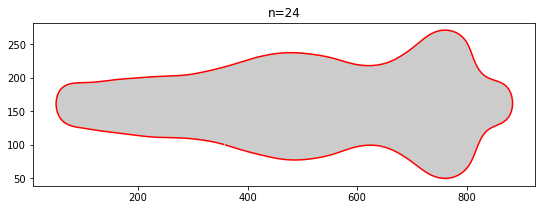

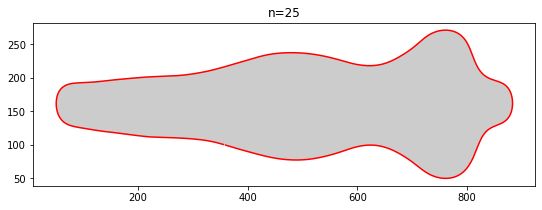

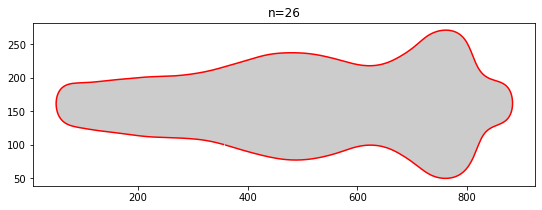

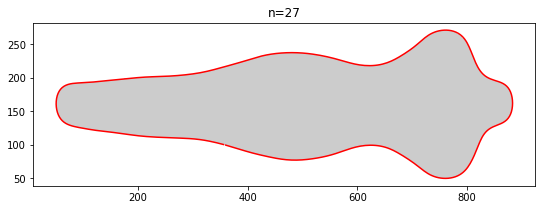

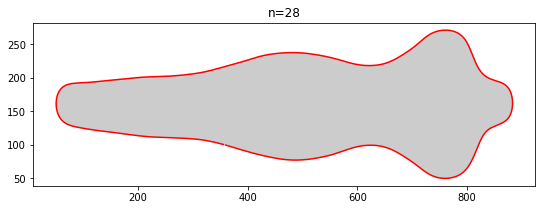

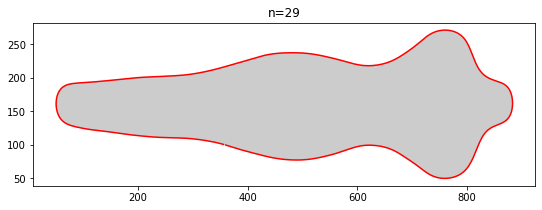

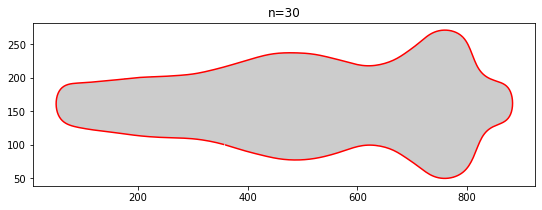

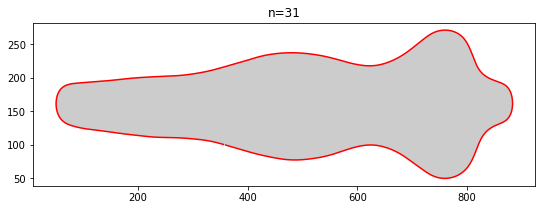

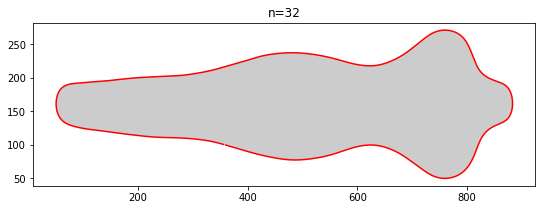

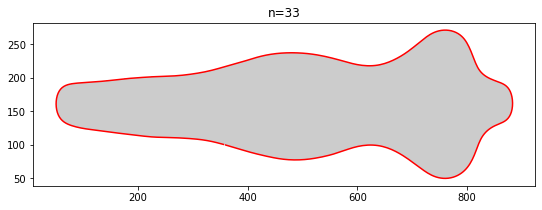

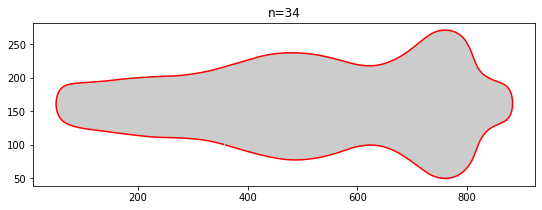

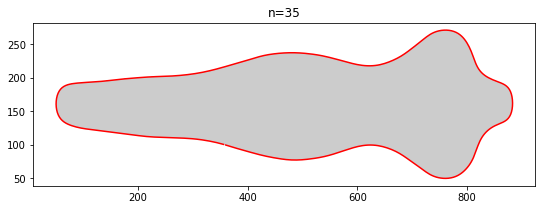

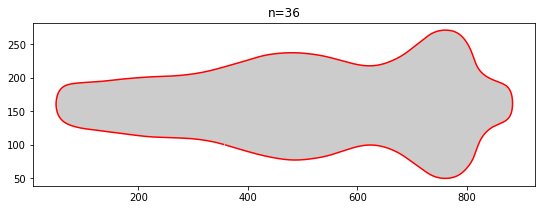

In [ ]:
#xeramos  i plots para cada harmónico
for i in np.arange(1,50):    #rango de harmómonicos a ser ploteado
    ief = iefourier(coef.an,coef.bn,coef.cn,coef.dn,i,n,ao,co)
    plt.fill(M[:,0],M[:,1],'k', alpha=0.2)

    plt.plot(ief['x'],ief['y'], 'r-')
    #plt.ylim((10,90))
    figsize(9,3)
    plt.title('n=%d'%(i-1))
    plt.show()
    #savefig('ief-%0d.png'%(i-1))
    plt.close()
    